In [5]:
import paddle.fluid as fluid
import paddle
import numpy as np
import os
import matplotlib.pyplot as plt

 **Step1：准备数据。**



In [6]:
BUF_SIZE=500
BATCH_SIZE=20

#用于训练的数据提供器，每次从缓存中随机读取批次大小的数据
train_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.uci_housing.train(), 
                          buf_size=BUF_SIZE),                    
    batch_size=BATCH_SIZE)   
#用于测试的数据提供器，每次从缓存中随机读取批次大小的数据
test_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.uci_housing.test(),
                          buf_size=BUF_SIZE),
    batch_size=BATCH_SIZE)  
    

In [7]:
#用于打印，查看uci_housing数据
train_data=paddle.dataset.uci_housing.train();
sampledata=next(train_data())
print(sampledata)

(array([-0.0405441 ,  0.06636364, -0.32356227, -0.06916996, -0.03435197,
        0.05563625, -0.03475696,  0.02682186, -0.37171335, -0.21419304,
       -0.33569506,  0.10143217, -0.21172912]), array([24.]))


 **Step2:网络配置**



In [8]:
#定义张量变量x，表示13维的特征值
x = fluid.layers.data(name='x', shape=[13], dtype='float32')
#定义张量y,表示目标值
y = fluid.layers.data(name='y', shape=[1], dtype='float32')
#定义一个简单的线性网络,连接输入和输出的全连接层
#input:输入tensor;
#size:该层输出单元的数目
#act:激活函数
y_predict=fluid.layers.fc(input=x,size=1,act=None)

**(2)定义损失函数**

此处使用均方差损失函数。

square_error_cost(input,lable):接受输入预测值和目标值，并返回方差估计,即为（y-y_predict）的平方

In [9]:
cost = fluid.layers.square_error_cost(input=y_predict, label=y) #求一个batch的损失值
avg_cost = fluid.layers.mean(cost)                              #对损失值求平均值

**(3)定义优化函数**

此处使用的是随机梯度下降。

In [10]:
optimizer = fluid.optimizer.SGDOptimizer(learning_rate=0.001)
opts = optimizer.minimize(avg_cost)

In [11]:
test_program = fluid.default_main_program().clone(for_test=True)

 **Step3.模型训练** and **Step4.模型评估**

**（1）创建Executor**


In [12]:

use_cuda = False                         #use_cuda为False,表示运算场所为CPU;use_cuda为True,表示运算场所为GPU           
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()
exe = fluid.Executor(place)              #创建一个Executor实例exe
exe.run(fluid.default_startup_program()) #Executor的run()方法执行startup_program(),进行参数初始化

[]

**（2）定义输入数据维度**



In [13]:
# 定义输入数据维度
feeder = fluid.DataFeeder(place=place, feed_list=[x, y])#feed_list:向模型输入的变量表或变量表名

**（3）定义绘制训练过程的损失值变化趋势的方法draw_train_process**

In [14]:
iter=0;
iters=[]
train_costs=[]

def draw_train_process(iters,train_costs):
    title="training cost"
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=14)
    plt.ylabel("cost", fontsize=14)
    plt.plot(iters, train_costs,color='red',label='training cost') 
    plt.grid()
    plt.show()

**（4）训练并保存模型**


Pass:0, Cost:765.61438
Test:0, Cost:248.20587
Pass:1, Cost:458.74023
Test:1, Cost:113.84402
Pass:2, Cost:561.00958
Test:2, Cost:162.97571
Pass:3, Cost:667.72009
Test:3, Cost:360.46750
Pass:4, Cost:386.10321
Test:4, Cost:135.42517
Pass:5, Cost:470.49066
Test:5, Cost:136.15494
Pass:6, Cost:438.30704
Test:6, Cost:33.79337
Pass:7, Cost:312.70990
Test:7, Cost:9.04340
Pass:8, Cost:251.40817
Test:8, Cost:126.66025
Pass:9, Cost:249.97879
Test:9, Cost:80.55891
Pass:10, Cost:190.79860
Test:10, Cost:19.96636
Pass:11, Cost:316.60037
Test:11, Cost:86.55441
Pass:12, Cost:195.32576
Test:12, Cost:211.34091
Pass:13, Cost:214.15686
Test:13, Cost:91.99792
Pass:14, Cost:169.08206
Test:14, Cost:2.32337
Pass:15, Cost:183.96014
Test:15, Cost:52.90580
Pass:16, Cost:73.53255
Test:16, Cost:31.73412
Pass:17, Cost:221.51355
Test:17, Cost:56.57844
Pass:18, Cost:126.64116
Test:18, Cost:9.67344
Pass:19, Cost:104.99064
Test:19, Cost:1.82172
Pass:20, Cost:365.06430
Test:20, Cost:42.25728
Pass:21, Cost:49.95150
Test:21

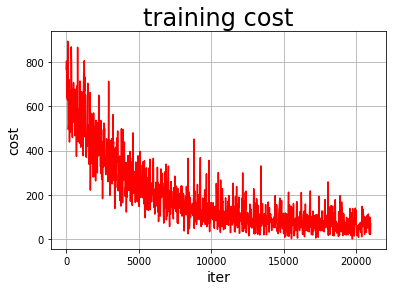

In [15]:
EPOCH_NUM=50
model_save_dir = "/home/aistudio/work/fit_a_line.inference.model"

for pass_id in range(EPOCH_NUM):                                  #训练EPOCH_NUM轮
    # 开始训练并输出最后一个batch的损失值
    train_cost = 0
    for batch_id, data in enumerate(train_reader()):              #遍历train_reader迭代器
        train_cost = exe.run(program=fluid.default_main_program(),#运行主程序
                             feed=feeder.feed(data),              #喂入一个batch的训练数据，根据feed_list和data提供的信息，将输入数据转成一种特殊的数据结构
                             fetch_list=[avg_cost])    
        if batch_id % 40 == 0:
            print("Pass:%d, Cost:%0.5f" % (pass_id, train_cost[0][0]))    #打印最后一个batch的损失值
        iter=iter+BATCH_SIZE
        iters.append(iter)
        train_costs.append(train_cost[0][0])
       
   
    # 开始测试并输出最后一个batch的损失值
    test_cost = 0
    for batch_id, data in enumerate(test_reader()):               #遍历test_reader迭代器
        test_cost= exe.run(program=test_program, #运行测试cheng
                            feed=feeder.feed(data),               #喂入一个batch的测试数据
                            fetch_list=[avg_cost])                #fetch均方误差
    print('Test:%d, Cost:%0.5f' % (pass_id, test_cost[0][0]))     #打印最后一个batch的损失值
    
    #保存模型
    # 如果保存路径不存在就创建
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
print ('save models to %s' % (model_save_dir))
#保存训练参数到指定路径中，构建一个专门用预测的program
fluid.io.save_inference_model(model_save_dir,   #保存推理model的路径
                                  ['x'],            #推理（inference）需要 feed 的数据
                                  [y_predict],      #保存推理（inference）结果的 Variables
                                  exe)              #exe 保存 inference model
draw_train_process(iters,train_costs)


 **Step5.模型预测**

**（1）创建预测用的Executor**

In [16]:
infer_exe = fluid.Executor(place)    #创建推测用的executor
inference_scope = fluid.core.Scope() #Scope指定作用域

**（2）可视化真实值与预测值方法定义**

In [17]:
infer_results=[]
groud_truths=[]

#绘制真实值和预测值对比图
def draw_infer_result(groud_truths,infer_results):
    title='Boston'
    plt.title(title, fontsize=24)
    x = np.arange(1,20) 
    y = x
    plt.plot(x, y)
    plt.xlabel('ground truth', fontsize=14)
    plt.ylabel('infer result', fontsize=14)
    plt.scatter(groud_truths, infer_results,color='green',label='training cost') 
    plt.grid()
    plt.show()

**(3)开始预测**

通过fluid.io.load_inference_model，预测器会从params_dirname中读取已经训练好的模型，来对从未遇见过的数据进行预测。

infer results: (House Price)
0: 14.93
1: 14.87
2: 14.85
3: 16.37
4: 15.72
5: 16.35
6: 15.58
7: 15.84
8: 13.88
9: 15.37
10: 13.00
11: 14.79
12: 15.38
13: 14.65
14: 14.34
15: 15.68
16: 16.30
17: 16.17
18: 16.52
19: 15.58
20: 16.04
21: 14.89
22: 16.41
23: 15.65
24: 15.77
25: 15.35
26: 16.36
27: 16.32
28: 16.99
29: 16.01
30: 15.76
31: 15.36
32: 15.43
33: 14.57
34: 14.26
35: 15.56
36: 15.54
37: 16.10
38: 16.25
39: 16.15
40: 15.19
41: 15.09
42: 16.10
43: 16.25
44: 16.21
45: 16.07
46: 15.78
47: 16.44
48: 16.45
49: 16.86
50: 15.64
51: 15.84
52: 15.41
53: 15.57
54: 16.35
55: 16.62
56: 16.45
57: 16.75
58: 16.81
59: 17.07
60: 17.27
61: 17.14
62: 15.85
63: 16.43
64: 16.87
65: 17.28
66: 17.16
67: 17.54
68: 17.54
69: 17.89
70: 16.35
71: 16.19
72: 16.87
73: 15.58
74: 16.61
75: 17.03
76: 18.01
77: 18.32
78: 18.50
79: 18.16
80: 17.73
81: 18.03
82: 17.24
83: 17.73
84: 17.16
85: 16.56
86: 15.96
87: 17.33
88: 17.87
89: 21.01
90: 21.15
91: 20.93
92: 19.98
93: 20.69
94: 20.95
95: 20.47
96: 20.66
97: 21.83
9

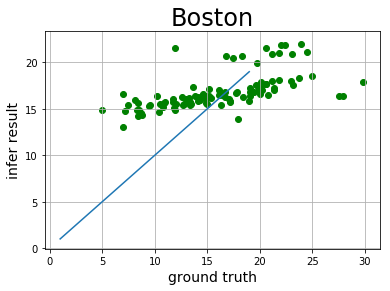

In [18]:
with fluid.scope_guard(inference_scope):#修改全局/默认作用域（scope）, 运行时中的所有变量都将分配给新的scope。
    #从指定目录中加载 推理model(inference model)
    [inference_program,                             #推理的program
     feed_target_names,                             #需要在推理program中提供数据的变量名称
     fetch_targets] = fluid.io.load_inference_model(#fetch_targets: 推断结果
                                    model_save_dir, #model_save_dir:模型训练路径 
                                    infer_exe)      #infer_exe: 预测用executor
    #获取预测数据
    infer_reader = paddle.batch(paddle.dataset.uci_housing.test(),  #获取uci_housing的测试数据
                          batch_size=200)                           #从测试数据中读取一个大小为200的batch数据
    #从test_reader中分割x
    test_data = next(infer_reader())
    test_x = np.array([data[0] for data in test_data]).astype("float32")
    test_y= np.array([data[1] for data in test_data]).astype("float32")
    results = infer_exe.run(inference_program,                              #预测模型
                            feed={feed_target_names[0]: np.array(test_x)},  #喂入要预测的x值
                            fetch_list=fetch_targets)                       #得到推测结果 
                            
    print("infer results: (House Price)")
    for idx, val in enumerate(results[0]):
        print("%d: %.2f" % (idx, val))
        infer_results.append(val)
    print("ground truth:")
    for idx, val in enumerate(test_y):
        print("%d: %.2f" % (idx, val))
        groud_truths.append(val)
    draw_infer_result(groud_truths,infer_results)